# [1] 카메라 이론

## 1. 병진 행렬: `trans_t(t)`

```python
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()
```

- 이 함수는 카메라를 **Z축 방향으로 $t$만큼 평행이동**시키는 **4×4 병진(translation) 행렬**을 생성합니다.
- 동차좌표(homogeneous coordinates)에서 $[X, Y, Z, 1]^T$ 에 이 행렬을 곱해보면, 결과는 $[X, Y, Z + t, 1]^T$가 되어 Z축으로 $t$만큼 이동함을 확인할 수 있습니다.

수식으로는 다음과 같이 나타낼 수 있습니다.

$$
\mathbf{T}_z(t) = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & t \\
0 & 0 & 0 & 1
\end{bmatrix}.
$$


## 2. X축 회전 행렬: `rot_phi(phi)`

```python
rot_phi = lambda phi : torch.Tensor([
    [1,0,          0,           0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,          0,           1]]).float()
```

- 이 함수는 **X축(오른손 법칙, right-hand rule 기준)**으로 $\phi$ 라디안을 회전시키는 4×4 회전 행렬을 생성합니다.
- 오른손 법칙에 따라, X축을 엄지로 두고 네 손가락이 돌아가는 방향을 양(+)의 회전 방향으로 정의합니다.  
- 즉, X축이 고정이고, $(Y, Z)$ 평면 상에서 $\phi$만큼 회전한다고 볼 수 있습니다.

수식으로는, 3차원 회전(동차좌표 포함 시 4×4)에서 잘 알려진 다음 형태가 됩니다.

$$
\mathbf{R}_x(\phi) = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & \cos\phi & -\sin\phi & 0 \\
0 & \sin\phi & \cos\phi & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}.
$$


## 3. Y축 회전 행렬: `rot_theta(th)`

```python
rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()
```

- 이 함수는 **Y축으로 $\theta$ 라디안을 회전**시키는 4×4 회전 행렬을 생성합니다.
- 보통 우리가 아는 오른손 법칙에 따르면, Y축을 잡고 엄지를 위로 세웠을 때 네 손가락이 돌아가는 방향이 **양(+) 회전**입니다.  
  - 그러나 NeRF 코드에서 $\sin(\theta)$ 앞에 ‘$-$’가 붙어 있지 않고, 대신 $\cos\theta$와 $-\sin\theta$의 위치가 다른 것을 볼 수 있습니다.
  - NeRF는 Y축과 Z축을 뒤바꾸는 최종 변환 과정에서 X 값에도 반전을 주는데, 이 때 phi와 theta가 통일성 있게 반대로 회전할 수 있도록 회전 행렬을 음수로 세팅한 것입니다. (이에 대한 자세한 설명은 하단 코드에서 다룹니다.)

즉, 이론적으로는 다음과 같은 표준 Y축 회전 행렬을 많이 사용합니다.

$$
\mathbf{R}_y(\theta) = 
\begin{bmatrix}
\cos\theta & 0 & \sin\theta & 0 \\
0 & 1 & 0 & 0 \\
-\sin\theta & 0 & \cos\theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}.
$$

하지만 코드에서는
$$
\begin{bmatrix}
\cos\theta & 0 & -\sin\theta & 0 \\
0 & 1 & 0 & 0 \\
\sin\theta & 0 & \cos\theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$
형태라서 반대로 회전하게 됩니다.


## 4. `pose_spherical(theta, phi, radius)`

```python
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],
                                 [0,0,1,0],
                                 [0,1,0,0],
                                 [0,0,0,1]])) @ c2w
    return c2w
```

이 함수는 다음 단계를 통해 **월드 좌표계에서 카메라 좌표계로 가는 4×4 변환 행렬(Extrinsic Matrix)**을 생성합니다.

1. **`text{trans_t}(radius)`**  
   $\; \rightarrow$ 원점에서 Z축 방향(또는 어떤 기준축)으로 $radius$만큼 떨어진 위치에 **카메라를 배치**합니다.  
   즉, 카메라를 구(球) 표면(반지름 = radius) 위에 두기 위한 준비입니다.

2. **`rot_phi(phi/180.*np.pi) @ c2w`**  
   $\; \rightarrow$ X축을 기준으로 $\phi$도 회전(단위는 degree에서 radian으로 변환).  
   이는 카메라의 고도(Elevation, 보통 $\phi$)를 조절한다. (예: 위아래로 보는 각도)

3. **`rot_theta(theta/180.*np.pi) @ c2w`**  
   $\; \rightarrow$ Y축을 기준으로 $\theta$도 회전.  
   이는 카메라의 방위(Azimuth, 보통 $\theta$)를 조절한다. (예: 좌우로 회전)

4. **마지막 매트릭스 곱**  
   ```python
   torch.Tensor(np.array([
       [-1, 0, 0, 0],
       [ 0, 0, 1, 0],
       [ 0, 1, 0, 0],
       [ 0, 0, 0, 1]
   ])) @ c2w
   ```
   - 이 행렬은 **축 재배열**(swizzling)과 부호 반전을 일부 포함합니다.
   - $[0,0,1]$과 $[0,1,0]$로 Y, Z축을 서로 교환하여 theta 값이 증가할 때 카메라가 Y 축이 아닌 Z축을 중심으로 회전하게 만듭니다.  
   - 그러나 이렇게 만들어진 대칭 행렬은 카메라의 이동을 추적하는 행렬 변환에서 사용하지 않습니다. 대칭 행렬은 이동이나 회전이 아니기 때문에, 카메라의 축을 반전시킬 수 있기 때문입니다.
   - 따라서 해당 행렬에 추가적으로 X축을 반전시켜 연속적인 회전 변환으로 분해할 수 있는 행렬을 만들어줍니다.

요약하면, $\mathbf{c2w}$ 행렬은 **“카메라가 $(\theta,\phi)$ 각도로 구면 좌표계에서 원점을 바라보되, 거리는 $radius$만큼 떨어진 지점에 위치”**하도록 만들어주는 변환 행렬입니다.  
그리고 마지막 축 재배열을 통해, 결과적으로 카메라가 원점을 바라보게 설정됩니다.


## 5. “Extrinsic matrix와 c2w는 역행렬 관계”에 대하여

- 보통 **카메라의 Extrinsic Matrix**는 “월드에서 카메라로 가는 변환($\mathbf{W2C}$)”을 가리킵니다. 
- 여기서는 $\mathbf{C2W}$가 “카메라에서 월드로 가는 변환” 행렬이므로, 당연히 $\mathbf{W2C} = (\mathbf{C2W})^{-1}$ 관계가 성립합니다.
- 즉, “모델에서 바라보는 카메라” 관점(= 월드→카메라)과 “카메라에서 월드로” 관점($\mathbf{C2W}$)은 역행렬 관계라는 점을 알 수 있습니다.

# [2] pytransform3d 라이브러리를 이용한 카메라 시각화

In [1]:
import os
import imageio.v2 as imageio

import torch
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt

from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.rotations import active_matrix_from_intrinsic_euler_xyz
from pytransform3d.transformations import transform_from, plot_transform
from pytransform3d.camera import make_world_grid, world2image, plot_camera

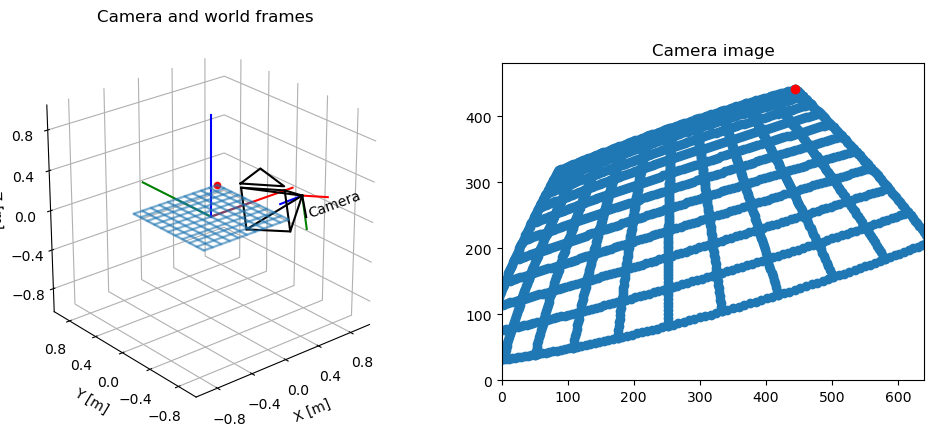

In [2]:
cam2world = transform_from(
    active_matrix_from_intrinsic_euler_xyz([-np.pi + 1, -0.1, 0.3]),
    [0.2, -1, 0.5])
focal_length = 0.0036
sensor_size = (0.00367, 0.00274)
image_size = (640, 480)
intrinsic_camera_matrix = np.array([
    [focal_length, 0, sensor_size[0] / 2],
    [0, focal_length, sensor_size[1] / 2],
    [0, 0, 1]
])

world_grid = make_world_grid(n_points_per_line=101)
image_grid = world2image(world_grid, cam2world, sensor_size, image_size,
                         focal_length, kappa=0.4)

plt.figure(figsize=(12, 5))
ax = make_3d_axis(1, 121, unit="m")
ax.view_init(elev=30, azim=-70)
plot_transform(ax)
plot_transform(ax, A2B=cam2world, s=0.3, name="Camera")
plot_camera(ax, intrinsic_camera_matrix, cam2world,
            sensor_size=sensor_size, virtual_image_distance=0.5)
ax.set_title("Camera and world frames")
ax.scatter(
    world_grid[:, 0], world_grid[:, 1], world_grid[:, 2], s=1, alpha=0.2)
ax.scatter(world_grid[-1, 0], world_grid[-1, 1], world_grid[-1, 2], color="r")
ax.view_init(elev=25, azim=-130)

ax = plt.subplot(122, aspect="equal")
ax.set_title("Camera image")
ax.set_xlim(0, image_size[0])
ax.set_ylim(0, image_size[1])
ax.scatter(image_grid[:, 0], -(image_grid[:, 1] - image_size[1]))
ax.scatter(image_grid[-1, 0], -(image_grid[-1, 1] - image_size[1]), color="r")

plt.show()

# [3] NeRF의 Cam to World Matrix 이해하기

## 1. Blender vs. pytransform3d의 기본 좌표계 차이

- **Blender 기본축**  
  - “Z축이 위”, “Y축이 전방”, “X축이 오른쪽” 형태로 씁니다.  
  - 또 Blender 카메라는 Z축의 음의 방향을 바라봅니다.
  - 즉, Blender에서 export된 `transform_matrix`는 “이 카메라가 -Z를 보고 있다”는 전제 아래, 월드 공간에서 어떤 위치/회전을 가졌는지 표현합니다.

- **pytransform3d**  
  - Blender 카메라와 달리 Z축의 양의 방향을 바라봅니다.
  - `plot_camera`는 “카메라의 optical axis가 +Z”일 때를 기본 전제로, 그 Frustum(사각뿔)을 그려주는 식입니다.

이렇게 서로 다른 축 정의가 섞이면,  
Blender에서 “-Z로 바라보는” 카메라를 그대로 시각화했을 때  
pytransform3d 입장에선 카메라가 정 반대의 후방을 바라보고있는 것처럼 그려집니다.  
따라서 이를 해결하기 위해 X축을 기준으로 카메라를 180도 회전시키는 전처리 작업이 필요합니다.


## 2. 왜 시각화 라이브러리에서 이동과 회전 행렬만을 사용할까?

예를 들어 **카메라 시각화**(pytransform3d 등)에서는,  
- “카메라가 어떤 방향을 보는지”를 **일관된 오른손좌표계(RHC)**로 표현해야  
- 광학축(+z인지 -z인지)을 정확히 정하고, 뷰 프러스텀 등을 자연스럽게 그릴 수 있습니다.

그러나 **반사 행렬**$(\det=-1$)이 들어오면,  
- “왼손좌표계”로 바뀌거나, 카메라 축이 뒤집히는 등  
- 내부적인 로직(광학축 +z)과 충돌을 일으킵니다.

따라서 카메라의 위치를 고려할 때는 이동과 회전만을 허용하며, $\det=-1$인 행렬은 시각화 라이브러리에서 사용할 수 없습니다. 그렇기 때문에 NeRF의 마지막 변환도
$$
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} \quad (\det = -1)
$$

대신에 아래와 같은 행렬을 사용하는 것입니다.
$$
\begin{bmatrix}
-1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} \quad (\det = 1)
$$

## 3. 회전 행렬과 반사 행렬의 판별

3차원에서 “길이와 직각(orthonormal basis)”을 보존하는 **정규직교 정변환**(orthogonal transformation)은 크게 두 부류로 나뉩니다:

1. **$\det=+1$**:  
   - **회전(Rotation)**만으로 설명되는 **“올바른 회전(proper rotation)”**.  
   - 공간의 **방향(orientation)을 보존**한다.  
   - 수학적으로 $\text{SO}(3)$ (특수직교군)이라 부름.

2. **$\det=-1$**:  
   - **축 뒤집기**, **거울 반사**, **rotoreflection(회전+반사)** 등을 포함하는 **“부적절 회전(improper rotation)”**.  
   - 공간의 **방향(orientation)을 뒤집음**.  
   - $\text{O}(3)\setminus\text{SO}(3)$ 부분에 해당.

따라서 **$\det=-1$**이라 해서 **역행렬이 없는** 것은 아닙니다.  
정규직교 행렬(길이·직각 보존)이기 때문에 물론 **가역**입니다(역행렬 존재).  
다만 “좌표계의 오른손/왼손잡이성을 뒤집는” 변환이 된다는 점이 **$\det=+1$**와의 본질적 차이입니다.

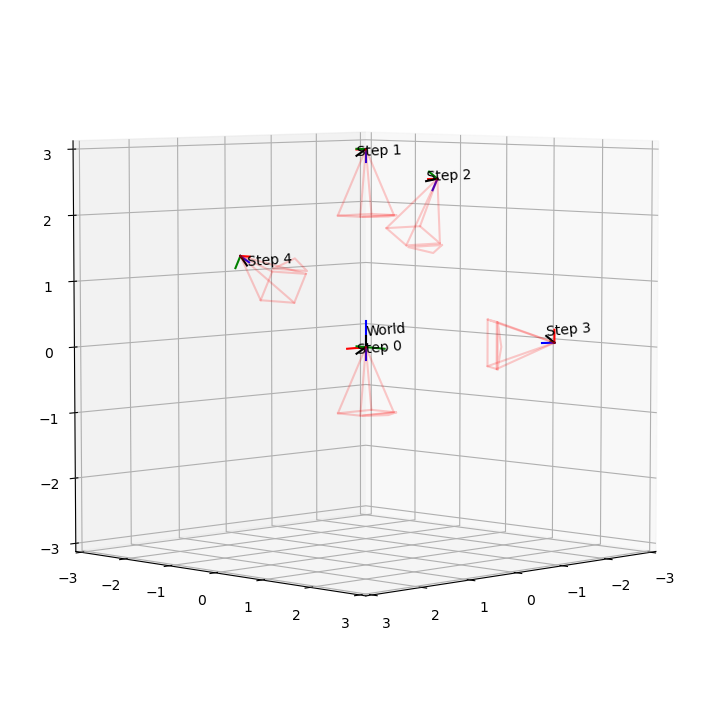

In [3]:
# Z축 t 평행이동
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

# X축 파이 회전
rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

# Y축 세타 회전
rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()

# X축 반전, Y-Z 스왑
swap_mat = torch.Tensor([
    [-1, 0, 0, 0],
    [ 0, 0, 1, 0],
    [ 0, 1, 0, 0],
    [ 0, 0, 0, 1]
])
'''
swap_mat = torch.Tensor([
    [ 1, 0, 0, 0],
    [ 0, 0, 1, 0],
    [ 0, 1, 0, 0],
    [ 0, 0, 0, 1]
])
카메라의 이동을 다룰 때, 반사는 오른손 좌표계를 반전시켜 충돌을 일으킬 수 있으므로, 오직 이동과 회전만 고려한다.
그러나 X축 반전이 없는 위 행렬은 det = -1인 반사 행렬로, 연속된 회전 행렬로 분해할 수 없다. (연쇄 회전 행렬의 det = 1이다.)
따라서 어쩔 수 없이 X 축에 반전을 주는 것이다.
'''

'''
해당 함수에서 원본 코드에 있는 변수의 이름인 c2w를 그대로 사용하였지만, 여기서는 정 반대의 정보인 w2c(extrinsic matrix)를 구하기 위해 사용됩니다.
즉, 월드 좌표계에 곱하여 카메라 좌표계로 이동하는 행렬에 대한 정보가 담겨있습니다.
'''
def pose_spherical(phi, theta, radius):
    c2w_list = []

    # 중요! pytransfrom3d의 카메라는 Z축을 바라보고 있지만, blender dataset의 카메라는 -Z축을 바라보고 있으므로
    # 먼저 X축 기준으로 180도 회전시켜 두 카메라를 얼라인 해야 한다.
    c2w = rot_phi(180/180.*np.pi)
    c2w_list.append(c2w.clone())

    # 1) 평행이동
    c2w = trans_t(radius) @ c2w
    c2w_list.append(c2w.clone())  # clone()으로 복사
    
    # 2) rot_phi 곱
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w_list.append(c2w.clone())
    
    # 3) rot_theta 곱
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w_list.append(c2w.clone())
    
    # 4) 마지막 행렬 곱
    c2w = swap_mat @ c2w
    c2w_list.append(c2w.clone())
    
    return c2w_list  # 모든 단계를 반환 (리스트)


# 단순 시각화를 위한 카메라 내부 매트릭스 인자값 지정
intrinsic_matrix = np.array([
    [0.05, 0,    0.036/2.0],
    [0,    0.05, 0.024/2.0],
    [0,    0,    1]
])
sensor_size = np.array([0.036, 0.024])
virtual_image_distance = 1.0 # 뷰 프러스텀 크기


# pose_spherical로부터 단계별 c2w 가져오기
phi, theta, radius = -30, 90, 3
'''
phi의 값이 30이 아닌 -30인 이유도 swap_mat 때문이다.
'''
c2w_list = pose_spherical(phi, theta, radius)  # [torch.Tensor(4x4), ...]

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.4, name="World")

for i, c2w_torch in enumerate(c2w_list):
    c2w_np = c2w_torch.numpy()  # pytransform3d는 np.array로 다룸
    
    # 좌표축 그리기 (원점+3축)
    ax = pt.plot_transform(
        A2B=c2w_np,  # (4x4) 카메라->월드 행렬
        ax=ax, 
        s=0.2,        # 좌표축 스케일
        name=f"Step {i}"
    )
    
    # 카메라 프러스텀 그리기
    pc.plot_camera(
        ax=ax,
        cam2world=c2w_np,        # (4x4) 카메라->월드
        M=intrinsic_matrix,      
        sensor_size=sensor_size,
        virtual_image_distance=virtual_image_distance,
        label=f"Step {i}",
        color="red", 
        alpha=0.2
    )

# 보기 편하도록 뷰 설정: elev(위에서 내려보는 각도), azim(수평 회전)
ax.view_init(elev=5, azim=45)

# 카메라들이 너무 바깥이면 축 범위를 넉넉히 설정
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])

# 3D 축 비율을 1:1:1로 맞추고 싶으면 pytransform3d의 set_3d_axes_equal 등을 사용할 수도 있음
# 여기서는 간단히 set_box_aspect 써도 됨 (matplotlib 3.3+)
ax.set_box_aspect((1,1,1))

plt.show()

In [4]:
def render_frame(phi, theta, radius, filename):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    virtual_image_distance = 1.0

    # pose_spherical로부터 단계별 c2w 가져오기
    c2w_list = pose_spherical(phi, theta, radius)  # [torch.Tensor(4x4), ...]

    pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.4, name="World")

    for i, c2w_torch in enumerate(c2w_list):
        c2w_np = c2w_torch.numpy()  # pytransform3d는 np.array로 다룸
        
        # 좌표축 그리기 (원점+3축)
        ax = pt.plot_transform(
            A2B=c2w_np,  # (4x4) 카메라->월드 행렬
            ax=ax, 
            s=0.2,        # 좌표축 스케일
            name=f"Step {i}"
        )
        
        # 카메라 프러스텀 그리기
        pc.plot_camera(
            ax=ax,
            cam2world=c2w_np,        # (4x4) 카메라->월드
            M=intrinsic_matrix,      
            sensor_size=sensor_size,
            virtual_image_distance=virtual_image_distance,
            label=f"Step {i}",
            color="red", 
            alpha=0.2
        )

    # 보기 편하도록 뷰 설정: elev(위에서 내려보는 각도), azim(수평 회전)


    # 카메라들이 너무 바깥이면 축 범위를 넉넉히 설정
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-4, 4])

    # 3D 축 비율을 1:1:1로 맞추고 싶으면 pytransform3d의 set_3d_axes_equal 등을 사용할 수도 있음
    # 여기서는 간단히 set_box_aspect 써도 됨 (matplotlib 3.3+)
    ax.set_box_aspect((1,1,1))

    # ax.view_init(elev=30, azim=0) ################
    # ax.view_init(elev=0, azim=90)
    # ax.view_init(elev=90, azim=0)
    ax.view_init(elev=10, azim=45)

    plt.title(f"phi={phi:.1f}, theta={theta:.1f}, radius={radius:.1f}")
    # plt.savefig(filename)
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

def create_animation_gif():
    # 저장 폴더
    out_dir = "frames"
    os.makedirs(out_dir, exist_ok=True)

    # 예: phi는 고정(45), theta를 0부터 360까지 10도 간격으로 변환
    #    radius도 예를 들어 4로 고정
    phi = -30
    radius = 4

    # 이미지 저장용 리스트
    images = []

    for i in range(120):
        theta = i * 3
        filename = os.path.join(out_dir, f"frame_{i:03d}.png")
        # 1) 프레임 그려서 PNG로 저장
        render_frame(phi, theta, radius, filename)

        # 2) 저장된 PNG 이미지를 읽어서 images 리스트에 쌓기
        img = imageio.imread(filename)
        images.append(img)

    # GIF 만들기 (frames/animation.gif)
    gif_path = os.path.join(out_dir, "animation.gif")
    imageio.mimsave(gif_path, images, fps=30, loop = 0)  # fps=5 → 초당 5프레임

    print(f"GIF saved to {gif_path}")

create_animation_gif()

GIF saved to frames/animation.gif


![alt text](frames/animation.gif)

phi를 -30도로 고정하고 theta를 움직였을 때, 최종 카메라의 궤적은 Z축을 중심으로 XZ평면을 바라보며 회전한다.

# [4] 블렌더 데이터셋 살펴보기

Blender로 생성된 NeRF 데이터셋(예: `transforms.json`)에서 흔히 볼 수 있는 필드는 다음과 같습니다:

1. **`camera_angle_x`**  
   - 카메라의 **수평(Horizontal) 화각(Field of View, FOV)** 을 의미합니다.  
   - 보통 **라디안**(radians) 단위로 표현되어, 예: `0.6911112070083618` 라면 약 `39.6°` 정도 ( `np.degrees(0.6911)` ≈ 39.6 ).  
   - 이 값을 통해 “카메라 내부 파라미터”에서 초점거리(f)나 화면 크기, 화각 간의 관계를 계산할 수 있습니다.

2. **`rotation`**  
   - 각 프레임(또는 이미지)에 대응하는 **회전값**인데, NeRF 원본 코드에서는 주로 **동영상이나 영상을 만들 때** 카메라를 부드럽게 회전(interpolate)시키기 위해 사용됩니다.  
   - 예컨데, `rotation = 0.0125663` 이런 값은 한 프레임에서 다음 프레임으로 넘어갈 때의 회전 정도(에니메이션용)를 가리키는 경우가 많습니다.  
     - 예: 2π를 약 6.28로 보면, 0.012566...은 2π/500 정도에 해당하므로, “프레임 간 아주 미세한 회전”을 나타낼 수 있습니다.  
   - 실제로 학습에서 “카메라를 회전시켜 가며 이미지 렌더링” 할 때 이 값을 이용해 프레임 사이를 보간하거나, 동영상 만들 때 스텝 크기로 활용합니다.

3. **`transform_matrix`**  
   - 4×4 동차 변환 행렬로, **카메라 좌표계 → 월드 좌표계** 변환(또는 그 반대)을 나타냅니다.  
   - Blender 등에서 내보낼 때, 보통 “카메라가 어떤 위치(R, t)에 있는지”를 직렬화하여 JSON으로 저장하는데, 이 행렬이 **카메라의 외부 파라미터(Extrinsics)** 역할을 합니다.  
   - 예: 
     \[
     \begin{bmatrix}
     -0.9999 & 0.0042 & -0.0133 & \dots \\
     -0.0139 & -0.2996 & 0.9539 & \dots \\
     \dots & \dots & \dots & \dots \\
     0 & 0 & 0 & 1
     \end{bmatrix}
     \]
     이런 형태로, 회전(3×3)과 평행이동(3×1)이 합쳐진 형태입니다.

---

## 요약

- **`camera_angle_x`**: 카메라의 가로 화각(FOV), 라디안 단위.  
- **`rotation`**: 주로 프레임 간 **회전 애니메이션**을 위한 작은 각도(혹은 스텝) 정보를 저장. (학습 시에는 크게 쓰이지 않고, 영상/회전 경로 보간 등에 사용)  
- **`transform_matrix`**: 카메라의 **외부 파라미터(Extrinsics)**로서, 카메라에서 월드로(또는 그 반대) 가는 변환 행렬을 4×4 동차 좌표계로 표현한 것.  

In [5]:
import json

In [6]:
# data practice
_datadir = './data/nerf_synthetic/lego'

with open(os.path.join(_datadir, 'transforms_test.json'), 'r') as fp:
    meta = json.load(fp)

print(meta['camera_angle_x'])
print(meta['frames'][0])
print(meta['frames'][0]['transform_matrix'])

rotations = []
transform_matrixes = []

print(len(meta['frames']))

for i in range(len(meta['frames'])):
    rotations.append(meta['frames'][i]['rotation'])
    transform_matrixes.append(meta['frames'][i]['transform_matrix'])

0.6911112070083618
{'file_path': './test/r_0', 'rotation': 0.031415926535897934, 'transform_matrix': [[-0.9999999403953552, 0.0, 0.0, 0.0], [0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708], [0.0, 0.6790306568145752, 0.7341098785400391, 2.959291696548462], [0.0, 0.0, 0.0, 1.0]]}
[[-0.9999999403953552, 0.0, 0.0, 0.0], [0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708], [0.0, 0.6790306568145752, 0.7341098785400391, 2.959291696548462], [0.0, 0.0, 0.0, 1.0]]
200


In [7]:
# print(rotations)
# print(transform_matrixes[0])

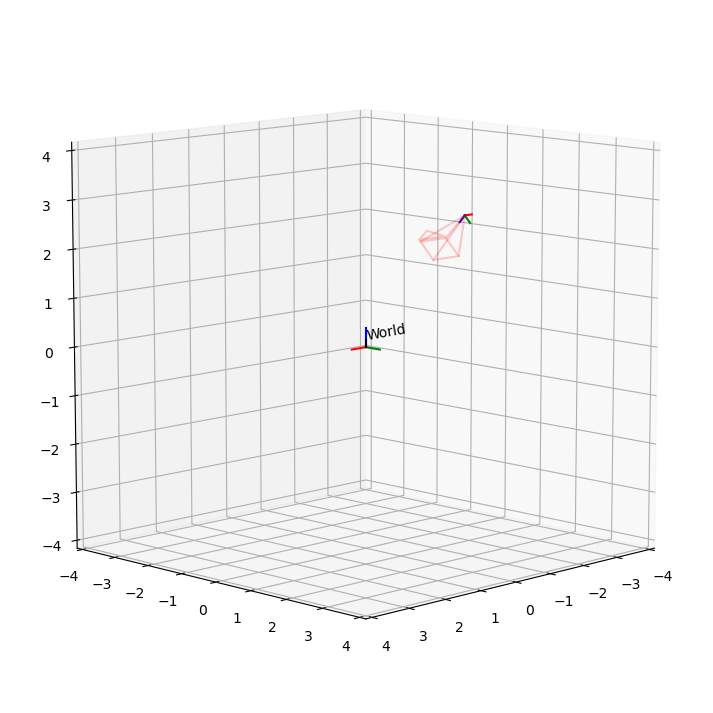

In [8]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.4, name="World")

# pytransform3d와 blender dataset의 카메라 얼라인(X축 180도 회전)
fix_mat = np.array([
    [1,  0,  0, 0],
    [0, -1,  0, 0],
    [0,  0, -1, 0],
    [0,  0,  0, 1]
])

# 블렌더 데이터셋 중 하나의 transform_matrix
c2w_list = [[-0.9999999403953552, 0.0, 0.0, 0.0],
            [0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708],
            [0.0, 0.6790306568145752, 0.7341098785400391, 2.959291696548462],
            [0.0, 0.0, 0.0, 1.0]]

c2w_np = np.array(c2w_list) @ fix_mat

# 좌표축 그리기 (원점+3축)
ax = pt.plot_transform(
    A2B=c2w_np,  # (4x4) 카메라->월드 행렬
    ax=ax, 
    s=0.2,        # 좌표축 스케일
    # name=f"Step {i}"
)

# 카메라 프러스텀 그리기
pc.plot_camera(
    ax=ax,
    cam2world=c2w_np,        # (4x4) 카메라->월드
    M=intrinsic_matrix,      
    sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance,
    # label=f"Step {i}",
    color="red", 
    alpha=0.2
)

# 보기 편하도록 뷰 설정: elev(위에서 내려보는 각도), azim(수평 회전)
ax.view_init(elev=10, azim=45)

# 카메라들이 너무 바깥이면 축 범위를 넉넉히 설정
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.set_zlim([-4, 4])

# 3D 축 비율을 1:1:1로 맞추고 싶으면 pytransform3d의 set_3d_axes_equal 등을 사용할 수도 있음
# 여기서는 간단히 set_box_aspect 써도 됨 (matplotlib 3.3+)
ax.set_box_aspect((1,1,1))

plt.show()

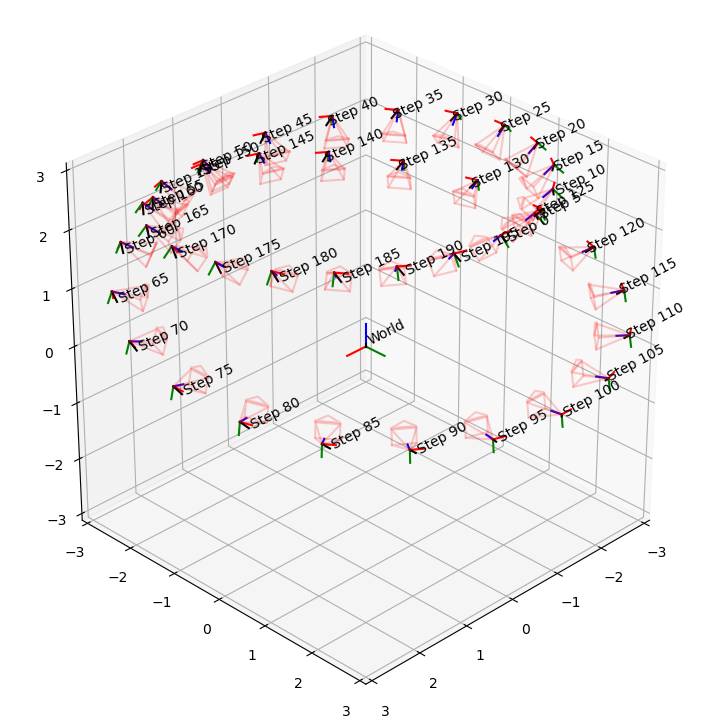

In [9]:
# pytransform3d와 blender dataset의 카메라 얼라인(X축 180도 회전)
fix_mat = np.array([
    [1,  0,  0, 0],
    [0, -1,  0, 0],
    [0,  0, -1, 0],
    [0,  0,  0, 1]
])

virtual_image_distance = 0.5
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.4, name="World")

for i, c2w_list in enumerate(transform_matrixes):
    if i % 5 == 0:
        # c2w_np = np.array(c2w_list) # pytransform3d는 np.array로 다룸
        c2w_np = np.array(c2w_list) @ fix_mat
        
        # 좌표축 그리기 (원점+3축)
        ax = pt.plot_transform(
            A2B=c2w_np,  # (4x4) 카메라->월드 행렬
            ax=ax, 
            s=0.2,        # 좌표축 스케일
            name=f"Step {i}"
        )
        
        # 카메라 프러스텀 그리기
        pc.plot_camera(
            ax=ax,
            cam2world=c2w_np,        # (4x4) 카메라->월드
            M=intrinsic_matrix,      
            sensor_size=sensor_size,
            virtual_image_distance=virtual_image_distance,
            label=f"Step {i}",
            color="red", 
            alpha=0.2
        )

# 보기 편하도록 뷰 설정: elev(위에서 내려보는 각도), azim(수평 회전)
ax.view_init(elev=30, azim=45)

# 카메라들이 너무 바깥이면 축 범위를 넉넉히 설정
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])

# 3D 축 비율을 1:1:1로 맞추고 싶으면 pytransform3d의 set_3d_axes_equal 등을 사용할 수도 있음
# 여기서는 간단히 set_box_aspect 써도 됨 (matplotlib 3.3+)
ax.set_box_aspect((1,1,1))

plt.show()

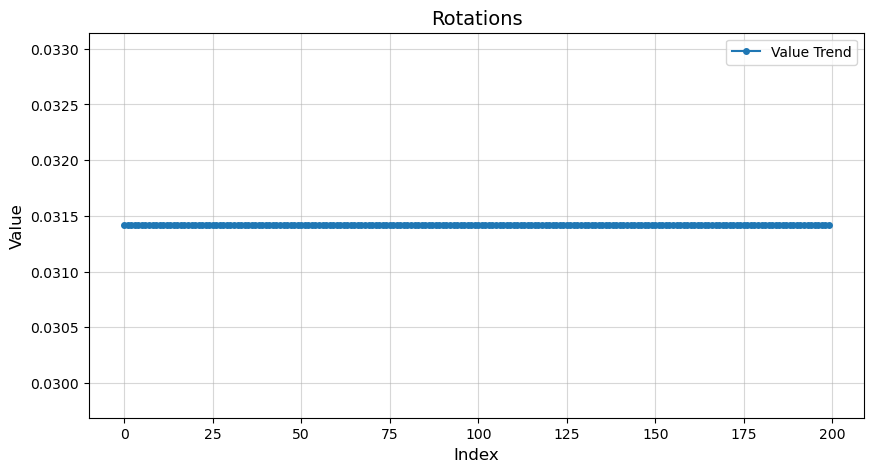

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(rotations, marker='o', linestyle='-', markersize=4, label='Value Trend')
plt.title("Rotations", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()